# **Importing Libraries**

In [107]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

#!pip install yfinance
#!pip install quantstats

import yfinance as yf
import datetime as dt
import quantstats as qs
from statsmodels.tsa.stattools import coint

import warnings
warnings.filterwarnings('ignore')

In [108]:
#!pip install --upgrade yfinance

# **Importing Dataset**

In [109]:
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
tables = pd.read_html(url)

sp500_table = tables[0]
tickers_list = sp500_table['Symbol'].tolist()

tickers_list = [t.replace('.', '-') for t in tickers_list]

print(len(tickers_list), "tickers found:", tickers_list[:10])

503 tickers found: ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']


In [110]:
Data = yf.download(tickers_list,start='2017-06-01',end='2020-06-01',interval='1d')

[*********************100%***********************]  503 of 503 completed
ERROR:yfinance:
12 Failed downloads:
ERROR:yfinance:['DASH', 'EXE', 'KVUE', 'GEHC', 'GEV', 'PLTR', 'SW', 'SOLV', 'CEG', 'ABNB', 'VLTO', 'COIN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2017-06-01 -> 2020-06-01) (Yahoo error = "Data doesn\'t exist for startDate = 1496289600, endDate = 1590984000")')


# **Data Preprocessing**

<Axes: >

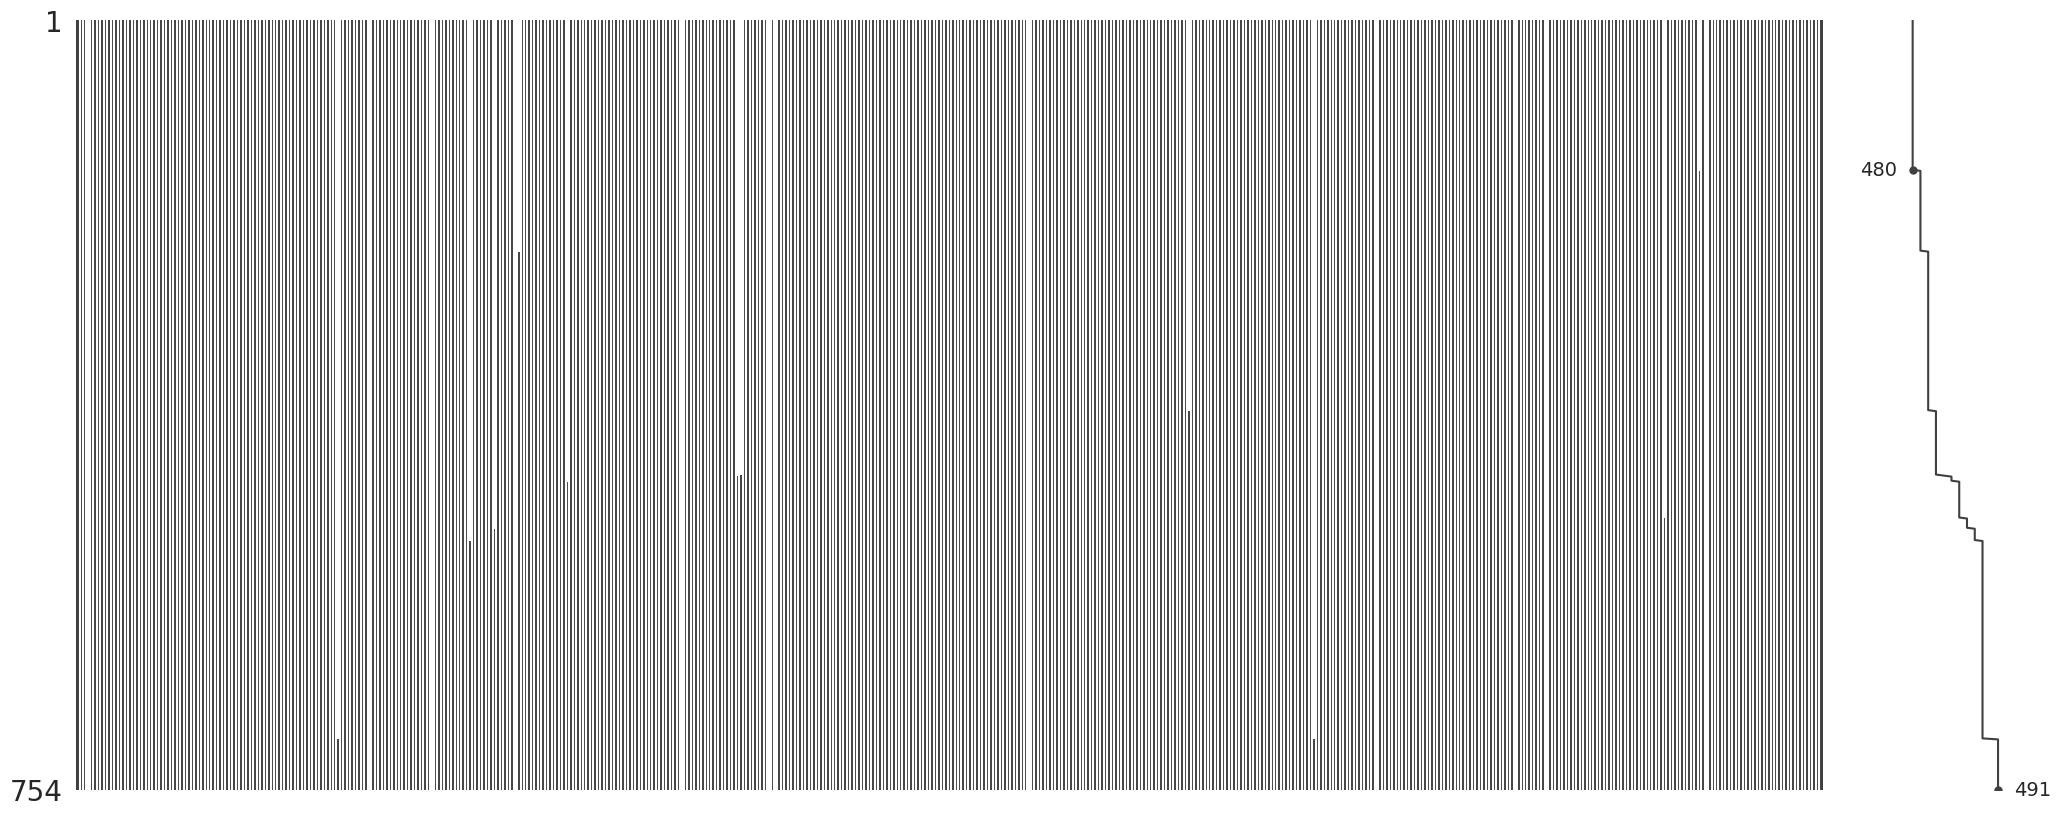

In [111]:
msno.matrix(Data['Close'])

In [112]:
def clean_stock_data(data):
    data = data.copy()

    for ticker in data.columns:
        missing_count = data[ticker].isna().sum()

        if missing_count / len(data[ticker]) >= 0.2:
            data = data.drop(columns=[ticker])
        else:
            mean_value = data[ticker].mean()
            data[ticker] = data[ticker].fillna(mean_value)

    return data

Data = clean_stock_data(Data)

Data = Data.ffill().bfill()

# **Clustering of Stocks**

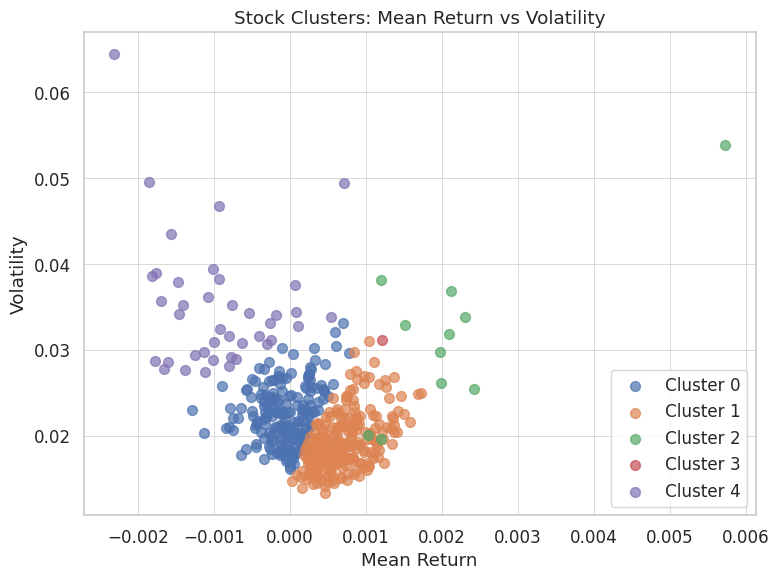

In [113]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def prepare_features(df):
    close = df['Close']
    vol   = df['Volume']

    log_ret = np.log(close / close.shift(1)).dropna()
    mean_return = log_ret.mean().rename('mean_return')
    volatility  = log_ret.std().rename('volatility')
    mean_volume = vol.mean().rename('mean_volume')

    features = pd.concat([mean_return, volatility, mean_volume], axis=1)
    return features

def cluster_stocks(features, n_clusters=5, random_state=42):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)

    km = KMeans(n_clusters=n_clusters, random_state=random_state)
    labels = km.fit_predict(X_scaled)

    return pd.Series(labels, index=features.index, name='Cluster')

def plot_clusters(features, clusters):
    """
    features : DataFrame with columns ['mean_return','volatility',…]
    clusters : Series mapping index of features → integer cluster label
    """
    df = features.copy()
    df['Cluster'] = clusters

    plt.figure(figsize=(8,6))
    for label, sub in df.groupby('Cluster'):
        plt.scatter(
            sub['mean_return'],
            sub['volatility'],
            s=50,
            alpha=0.7,
            label=f'Cluster {label}'
        )

    plt.xlabel('Mean Return')
    plt.ylabel('Volatility')
    plt.title('Stock Clusters: Mean Return vs Volatility')
    plt.legend()
    plt.tight_layout()
    plt.show()

Features = prepare_features(Data)
Clusters = cluster_stocks(Features, n_clusters=5)
plot_clusters(Features, Clusters)


# **Pair Selection**

In [114]:
Data = Data['Close']
Data.head()

Ticker,A,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2017-06-01,57.163094,35.680153,47.379219,39.995182,31.135586,110.820763,141.380005,70.258904,33.049591,86.854866,...,131.073792,24.280582,121.952660,37.413727,55.918255,47.649532,63.900475,111.531555,108.139999,59.029266
2017-06-02,57.238396,36.208893,47.762753,40.342213,31.313089,111.218765,143.479996,69.147896,33.365696,84.863129,...,131.565399,24.280582,122.947708,37.561405,55.086746,48.158386,64.038971,112.686241,107.750000,58.897327
2017-06-05,56.852486,35.854851,47.947407,40.446320,31.167286,111.961754,143.589996,67.301903,33.144421,84.963966,...,131.449234,24.186394,121.669678,37.188293,55.516369,48.340115,64.220718,112.677155,105.900002,59.057541
2017-06-06,56.570091,35.975986,48.203110,40.220737,30.790096,111.740623,143.029999,68.455635,33.152336,85.048012,...,129.965271,24.208134,121.048920,36.955086,56.271629,47.876694,64.324585,112.895355,105.239998,59.349663
2017-06-07,57.068970,36.190277,48.828087,40.394268,30.124466,111.935234,143.619995,69.469818,33.120716,85.309998,...,129.947433,24.149626,120.784172,37.234932,56.063747,48.576359,64.272675,113.059021,106.570000,59.613529


In [115]:
def find_correlation(Data, threshold = 0.9):

    correlationMatrix = Data.corr()
    n = correlationMatrix.shape[0]
    result = pd.DataFrame(columns=['Asset 1', 'Asset 2', 'Correlation Coefficient'])

    for i in range(n):
        for j in range(i + 1, n):
            correlation = correlationMatrix.iloc[i, j]
            if correlation >= threshold:
                result = pd.concat([result,
                                    pd.DataFrame({'Asset 1': [Data.columns[i]],
                                                  'Asset 2': [Data.columns[j]],
                                                  'Correlation Coefficient': [correlation]})],
                                   ignore_index=True)
    return result

def find_cointegrated_pairs(Data, df, threshold=0.01):

    result = pd.DataFrame(columns=['Asset 1', 'Asset 2', 'Correlation Coefficient','p-value'])

    for i in range(len(df)):

      stock_1 = df.iloc[i,0]
      stock_2 = df.iloc[i,1]
      correlation = df.iloc[i,2]
      p_value = coint(Data[stock_1], Data[stock_2])[1]
      if p_value <= threshold:
        result = pd.concat([result,
                                    pd.DataFrame({'Asset 1': [stock_1],
                                                  'Asset 2': [stock_2],
                                                  'Correlation Coefficient': [correlation],
                                                  'p-value':[p_value]})],
                                   ignore_index=True)
    return result

In [116]:
results = []

for cluster_label in Clusters.unique():
    tickers = Clusters[Clusters == cluster_label].index.tolist()

    sub_data = Data[tickers]

    sub_pairs = find_correlation(sub_data, threshold=0.9)

    if not sub_pairs.empty:
        sub_pairs['Cluster'] = cluster_label
        results.append(sub_pairs)

if results:
    correlatedPairs = pd.concat(results, ignore_index=True)
else:
    correlatedPairs = pd.DataFrame(
        columns=['Asset 1','Asset 2','Correlation Coefficient','Cluster']
    )

print(correlatedPairs)


     Asset 1 Asset 2  Correlation Coefficient  Cluster
0        ABT     ACN                 0.911568        1
1        ABT    ADBE                 0.935404        1
2        ABT     ADP                 0.906505        1
3        ABT     AEE                 0.917945        1
4        ABT     AJG                 0.935179        1
...      ...     ...                      ...      ...
4277     IVZ     SLB                 0.907816        4
4278    NCLH     RCL                 0.972879        4
4279     SLB     TPR                 0.931185        4
4280     SLB    VTRS                 0.925046        4
4281     TPR    VTRS                 0.916177        4

[4282 rows x 4 columns]


In [117]:
cointegratedPairs = find_cointegrated_pairs(Data, correlatedPairs)
cointegratedPairs

,Asset 1,Asset 2,Correlation Coefficient,p-value
0,ABT,CMG,0.927905,0.006591
1,ABT,MKC,0.951304,0.004082
2,ABT,VRSK,0.965651,0.003061
3,ABT,VRSN,0.972942,0.005699
4,ACN,CTAS,0.956139,0.002761
...,...,...,...,...
327,KMI,WELL,0.905192,0.006441
328,NI,UDR,0.907661,0.003660
329,NTAP,RL,0.915389,0.002772
330,NWS,NWSA,0.997555,0.000349


# Hedge Ratio

In [118]:
def calculate_hedge_ratio(df,Data):
    hedge_ratio = []
    n = df.shape[0]
    for i in range(n):
        covariance = np.cov(Data[df.iloc[i, 0]].values, Data[df.iloc[i, 1]].values)[0, 1]
        variance = np.var(Data[df.iloc[i, 1]])
        hedge_ratio.append(covariance/variance)
    return hedge_ratio


In [119]:
cointegratedPairs['Hedge Ratio'] = calculate_hedge_ratio(cointegratedPairs,Data)
cointegratedPairs

,Asset 1,Asset 2,Correlation Coefficient,p-value,Hedge Ratio
0,ABT,CMG,0.927905,0.006591,2.828984
1,ABT,MKC,0.951304,0.004082,0.962490
2,ABT,VRSK,0.965651,0.003061,0.477078
3,ABT,VRSN,0.972942,0.005699,0.314068
4,ACN,CTAS,0.956139,0.002761,1.910410
...,...,...,...,...,...
327,KMI,WELL,0.905192,0.006441,0.125636
328,NI,UDR,0.907661,0.003660,0.378244
329,NTAP,RL,0.915389,0.002772,0.576700
330,NWS,NWSA,0.997555,0.000349,1.025791


In [120]:
cointegratedPairs['criterion'] = np.abs(cointegratedPairs['Hedge Ratio'] - 1)
cointegratedPairs.sort_values(by='criterion', inplace=True)
cointegratedPairs

,Asset 1,Asset 2,Correlation Coefficient,p-value,Hedge Ratio,criterion
244,KDP,VZ,0.926299,0.005733,0.997217,0.002783
145,CTAS,J,0.936294,0.007376,1.004131,0.004131
76,ATO,RSG,0.959511,0.003930,0.987871,0.012129
40,AJG,WEC,0.923404,0.009662,0.981491,0.018509
75,ATO,MRK,0.934815,0.007374,0.977418,0.022582
...,...,...,...,...,...,...
48,ANSS,NDAQ,0.952876,0.001613,10.462390,9.462390
315,AVB,KMI,0.911452,0.004627,10.606278,9.606278
175,EPAM,FAST,0.956055,0.001573,18.300285,17.300285
81,AZO,ICE,0.918474,0.007471,20.153767,19.153767


To select from the remaining pairs we select the pair with Hedge Ratio closest to one.

# Calculating Spread and Z-Score

In [265]:
Stock_1 = cointegratedPairs['Asset 1'][0]
Stock_2 = cointegratedPairs['Asset 2'][0]
Hedge_ratio = cointegratedPairs['Hedge Ratio'][0]

tradingData=yf.download([Stock_1, Stock_2],start='2020-07-01',end='2023-07-01',interval='1d')

[*********************100%***********************]  2 of 2 completed


In [266]:
tradingData = tradingData['Close']

In [267]:
spread = tradingData[Stock_1] - tradingData[Stock_2]*Hedge_ratio

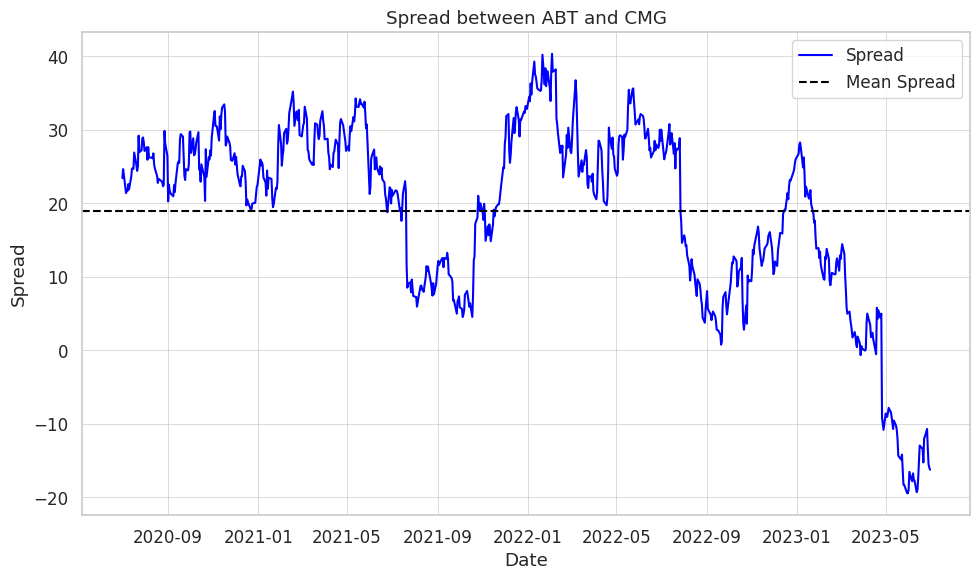

In [268]:
def plot_spread(spread, asset_1, asset_2):
    sns.set_style('whitegrid')
    plt.figure(figsize=(10, 6))

    sns.lineplot(x=spread.index, y=spread.values, label='Spread', color='blue')

    plt.axhline(spread.mean(), color='black', linestyle='--', label='Mean Spread')

    plt.title(f"Spread between {asset_1} and {asset_2}")
    plt.xlabel('Date')
    plt.ylabel('Spread')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_spread(spread, Stock_1, Stock_2)

In [269]:
def zscore(series):
    lookback = 21
    scores = []
    for i in range(lookback, len(series)):
      window = series[i-lookback:i]
      scores.append((series[i]-window.mean())/window.std())
    return pd.Series(scores, index = series.index[lookback:])

In [270]:
zscore = zscore(spread)

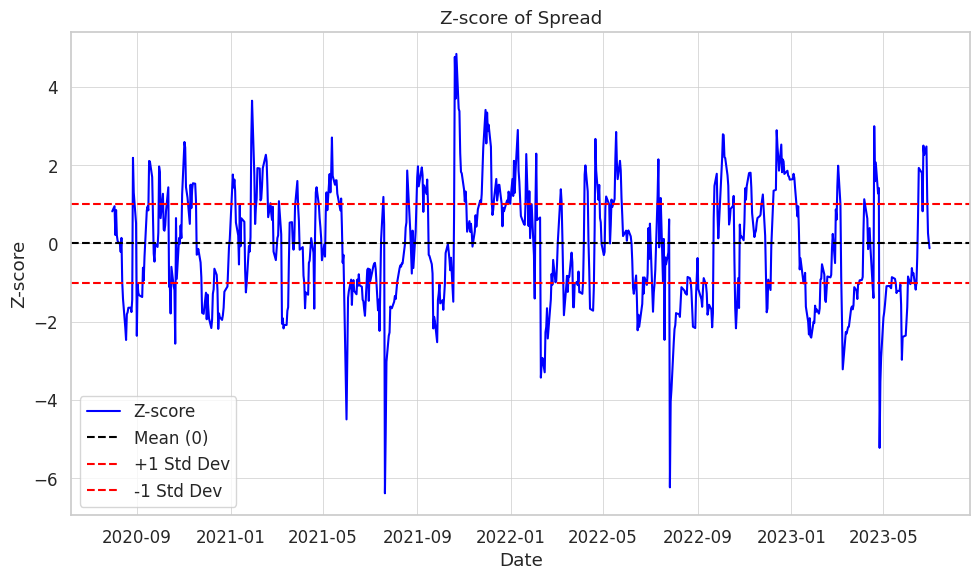

In [271]:
def plot_zscore(zscore):

    sns.set_style('whitegrid')
    plt.figure(figsize=(10, 6))

    sns.lineplot(x=zscore.index, y=zscore, label='Z-score', color='blue')

    plt.axhline(0, color='black', linestyle='--', label='Mean (0)')
    plt.axhline(1, color='red', linestyle='--', label='+1 Std Dev')
    plt.axhline(-1, color='red', linestyle='--', label='-1 Std Dev')

    plt.title(f'Z-score of Spread')
    plt.xlabel('Date')
    plt.ylabel('Z-score')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_zscore(zscore)

In [272]:
tradingData['Spread'] = spread
tradingData['Z-Score'] = zscore

# **Signal Generation**

In [273]:
def generate_signals(tradingData, threshold=1.0):
    tradingData['Signal 1'] = np.select([tradingData['Z-Score'] > threshold, tradingData['Z-Score'] < -1*threshold], [-1, 1], default = 0)
    tradingData['Signal 2'] = np.select([tradingData['Z-Score'] > threshold, tradingData['Z-Score'] < -1*threshold], [1, -1], default = 0)
    tradingData.dropna(inplace=True)
    return tradingData

generate_signals(tradingData)

Ticker,ABT,CMG,Spread,Z-Score,Signal 1,Signal 2
Date,,,,,,
2020-07-31,92.464035,23.103201,27.105439,0.819392,0,0
2020-08-03,92.500793,22.934200,27.620297,0.951384,0,0
2020-08-04,91.811722,23.291401,25.920711,0.215015,0,0
2020-08-05,93.842171,23.404800,27.630354,0.853077,0,0
2020-08-06,93.483864,23.736000,26.335089,0.208684,0,0
...,...,...,...,...,...,...
2023-06-26,104.263611,40.646198,-10.723852,2.476429,-1,1
2023-06-27,103.571785,41.334599,-13.363152,1.127785,-1,1
2023-06-28,103.398827,42.029800,-15.502826,0.262846,0,0


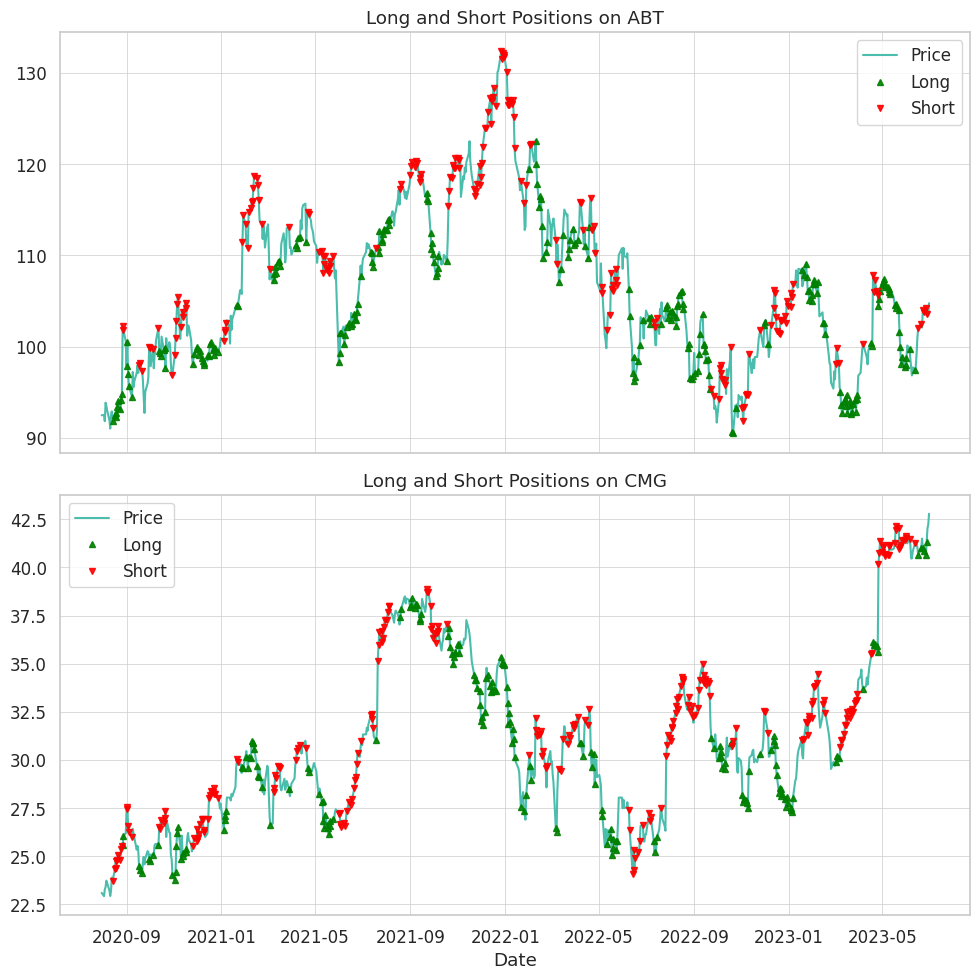

In [274]:
def plot_signals(tradingData):
    stock1 = tradingData.columns[0]
    stock2 = tradingData.columns[1]

    sns.set_style('whitegrid')
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

    # --- Asset 1 ---
    ax1 = axes[0]
    ax1.plot(tradingData[stock1], color='#4abdac', label='Price')

    long_signals_1 = tradingData[tradingData['Signal 1'] == 1]
    short_signals_1 = tradingData[tradingData['Signal 1'] == -1]

    ax1.plot(long_signals_1.index, long_signals_1[stock1], lw=0, marker='^', color='green', markersize=4, alpha=0.9, label='Long')
    ax1.plot(short_signals_1.index, short_signals_1[stock1], lw=0, marker='v', color='red', markersize=4, alpha=0.9, label='Short')

    ax1.set_title(f'Long and Short Positions on {stock1}')
    ax1.legend()

    # --- Asset 2 ---
    ax2 = axes[1]
    ax2.plot(tradingData[stock2], color='#4abdac', label='Price')

    long_signals_2 = tradingData[tradingData['Signal 2'] == 1]
    short_signals_2 = tradingData[tradingData['Signal 2'] == -1]

    ax2.plot(long_signals_2.index, long_signals_2[stock2], lw=0, marker='^', color='green', markersize=4, alpha=0.9, label='Long')
    ax2.plot(short_signals_2.index, short_signals_2[stock2], lw=0, marker='v', color='red', markersize=4, alpha=0.9, label='Short')

    ax2.set_title(f'Long and Short Positions on {stock2}')
    ax2.legend()

    plt.xlabel('Date')
    plt.tight_layout()
    plt.show()

plot_signals(tradingData)

# **Backtesting**

In [275]:
def backtest_pairs_trading(data, stock1, stock2, initial_capital=100000):
    capital = initial_capital
    w1, w2 = 0.5, 0.5

    position_stock1 = 0
    position_stock2 = 0
    current_signal = 0

    portfolio_values = []

    for index, row in data.iterrows():
        signal = row['Signal 1']

        if signal != current_signal:

            capital += position_stock1 * row[stock1] + position_stock2 * row[stock2]
            position_stock1 = 0
            position_stock2 = 0

            if signal == 1:
                position_stock1 = (capital * w1) // row[stock1]
                position_stock2 = -(capital * w2) // row[stock2]
                capital -= (position_stock1 * row[stock1] + position_stock2 * row[stock2])
            elif signal == -1:
                position_stock1 = -(capital * w1) // row[stock1]
                position_stock2 = (capital * w2) // row[stock2]
                capital -= (position_stock1 * row[stock1] + position_stock2 * row[stock2])

            current_signal = signal

        portfolio_value = capital + position_stock1 * row[stock1] + position_stock2 * row[stock2]
        portfolio_values.append(portfolio_value)

    data['Portfolio_Value'] = portfolio_values
    return data


In [276]:
tradingData = backtest_pairs_trading(tradingData, Stock_1, Stock_2)

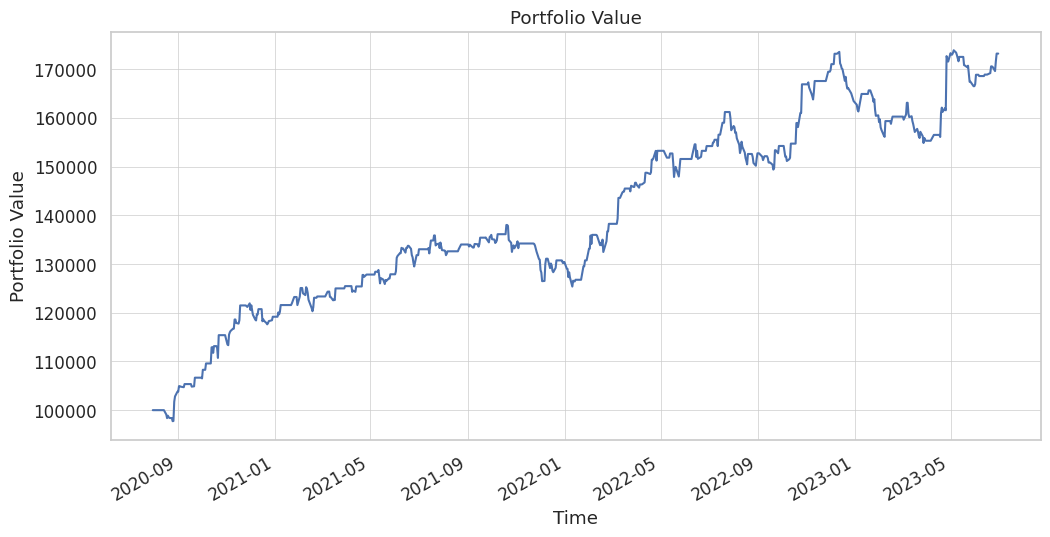

In [277]:
tradingData['Portfolio_Value'].plot(figsize=(12, 6), title='Portfolio Value')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.show()

# **Performance** **Metrics**

In [278]:
tradingData

Ticker,ABT,CMG,Spread,Z-Score,Signal 1,Signal 2,Portfolio_Value
Date,,,,,,,
2020-07-31,92.464035,23.103201,27.105439,0.819392,0,0,100000.000000
2020-08-03,92.500793,22.934200,27.620297,0.951384,0,0,100000.000000
2020-08-04,91.811722,23.291401,25.920711,0.215015,0,0,100000.000000
2020-08-05,93.842171,23.404800,27.630354,0.853077,0,0,100000.000000
2020-08-06,93.483864,23.736000,26.335089,0.208684,0,0,100000.000000
...,...,...,...,...,...,...,...
2023-06-26,104.263611,40.646198,-10.723852,2.476429,-1,1,169595.130590
2023-06-27,103.571785,41.334599,-13.363152,1.127785,-1,1,171593.611959
2023-06-28,103.398827,42.029800,-15.502826,0.262846,0,0,173180.762522


In [279]:
portfolio = tradingData['Portfolio_Value'].copy()
signals   = tradingData['Signal 1'].copy()

# ———————— basic stats ————————
initial_value = portfolio.iloc[0]
final_value   = portfolio.iloc[-1]
trading_days  = len(portfolio)
YEAR_DAYS     = 252

print(f"Number of trading days = {trading_days}")

# CAGR
cagr = ( final_value / initial_value ) ** ( YEAR_DAYS / trading_days ) - 1
print(f"CAGR = {cagr*100:.3f}%")

# Cumulative return
cum_ret = final_value / initial_value - 1
print(f"Cumulative Return = {cum_ret*100:.3f}%")

# ———————— risk metrics via quantstats ————————
max_dd = qs.stats.max_drawdown(portfolio)
print(f"Maximum Drawdown = {max_dd*100:.3f}%")

sharpe = qs.stats.sharpe(portfolio)
print(f"Sharpe Ratio = {sharpe:.3f}")

# ———————— trade frequency ————————
n_trades = abs(signals).diff().fillna(0).astype(bool).sum()
freq_per_year = n_trades / trading_days * YEAR_DAYS

print(f"Frequency of trades = {n_trades} trades total → {freq_per_year:.3f} per year")


Number of trading days = 734
CAGR = 20.749%
Cumulative Return = 73.181%
Maximum Drawdown = -10.776%
Sharpe Ratio = 1.621
Frequency of trades = 192 trades total → 65.918 per year
